In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

import shap

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

In [2]:
# Preparando o dataset
diretorio = 'heart+disease'

arquivos = os.listdir(diretorio)
arquivos = [arquivo for arquivo in arquivos if arquivo.startswith('processed.') and arquivo.endswith('.data')]

datasets = []
for arquivo in arquivos:
    dataset = pd.read_csv(os.path.join(diretorio, arquivo), header=None)
    datasets.append(dataset)

# Concatenando os datasets
dataset = pd.concat(datasets, ignore_index=True)

dataset.columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]

dataset.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
285,58.0,1.0,4.0,114.0,318.0,0.0,1.0,140.0,0.0,4.4,3.0,3.0,6.0,4
200,50.0,0.0,4.0,110.0,254.0,0.0,2.0,159.0,0.0,0.0,1.0,0.0,3.0,0
587,49.0,1.0,4.0,128,212,0,0,96,1,0.0,?,?,?,1
711,68.0,1.0,4.0,135,0,0,1,120,1,0,1,?,7,3
312,34.0,0.0,2.0,130,161,0,0,190,0,0.0,?,?,?,0


---
-  Analisando o dataset

In [3]:
dataset['target'].value_counts()

target
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

In [4]:
df = dataset.copy()

print (df.shape)
# excluindo linhas que tenham ao menos valor ?
df = df.replace('?', np.nan)
df.dropna(inplace=True)

print (df.shape)

(920, 14)
(299, 14)


- Não tem como minimamente excluir as linhas que apreentam "?". Vai excluir muitas linhas e tem uma perda grande. 
- Assim, vamos tentar fazer um preenchimento artificial, porém inteligente desses valores faltantes. 
- Vamos utilizar a biblioteca "".

In [5]:
knn_inputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')

df = dataset.copy()
df = df.replace('?', np.nan)
df = df.astype(float)
df_inputed = knn_inputer.fit_transform(df)

df = pd.DataFrame(df_inputed, columns=df.columns)
df['target'] = df['target'].astype(int)
df.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
317,35.0,1.0,2.0,120.0,308.0,0.0,2.0,180.0,0.0,0.0,1.1,0.3,4.1,0
469,56.0,0.0,3.0,130.0,219.0,0.5,1.0,164.0,0.0,0.0,1.1,0.6,7.0,0
277,39.0,0.0,3.0,138.0,220.0,0.0,0.0,152.0,0.0,0.0,2.0,0.0,3.0,0
634,52.0,1.0,4.0,135.0,0.0,0.2,0.0,128.0,1.0,2.0,2.0,1.0,7.0,2
494,35.0,1.0,2.0,110.0,257.0,0.0,0.0,140.0,0.0,0.0,1.7,0.3,5.0,1


---
- Vamos preparar o dataset para treinamento e teste

In [6]:
df_train = df.copy().drop(columns=['target'])
df_test = df.copy()['target']

scaler = MinMaxScaler(feature_range=(-1, 1))
df_train = scaler.fit_transform(df_train)

x_train, x_test, y_train, y_test = train_test_split(df_train, df_test, test_size=0.35, stratify=df_test)

print (f'{x_train.shape=}\n{x_test.shape=}\n{y_train.shape=}\n{y_test.shape=}')

x_train.shape=(598, 13)
x_test.shape=(322, 13)
y_train.shape=(598,)
y_test.shape=(322,)


In [7]:
def preparar_datasets(test_size_=0.25):
    """Função completa que traz os datasets já tratados em treino, teste"""
    knn_inputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')
    
    df = dataset.copy()
    df = df.replace('?', np.nan)
    df = df.astype(float)
    df_inputed = knn_inputer.fit_transform(df)

    df = pd.DataFrame(df_inputed, columns=df.columns)
    df['target'] = df['target'].astype(int)
    
    df_train = df.copy().drop(columns=['target'])
    df_test = df.copy()['target']

    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_train = scaler.fit_transform(df_train)

    x_train, x_test, y_train, y_test = train_test_split(df_train, df_test, test_size=test_size_, stratify=df_test)

    return x_train, x_test, y_train, y_test

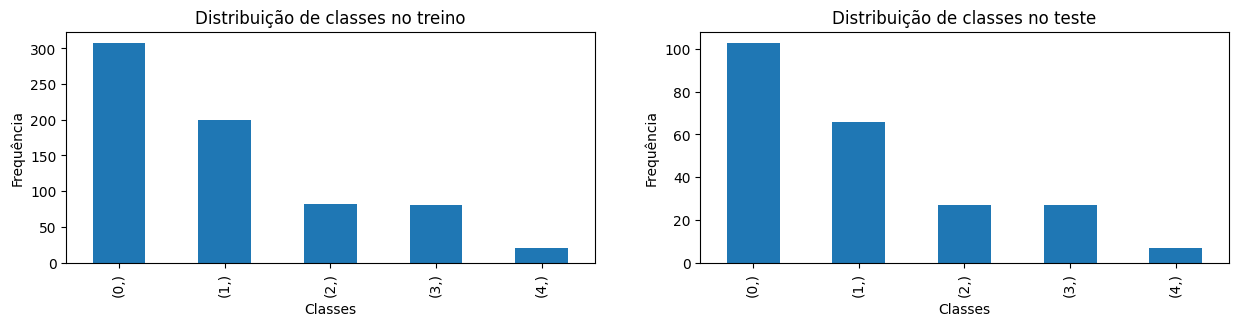

In [8]:
x_train, x_test, y_train, y_test = preparar_datasets(test_size_=0.25)

grafico = plt.figure(figsize=(15, 3))

grafico.add_subplot(1, 2, 1)
pd.DataFrame(y_train).value_counts().plot(kind='bar', title='Distribuição de classes no treino', xlabel='Classes', ylabel='Frequência')

grafico.add_subplot(1, 2, 2)
pd.DataFrame(y_test).value_counts().plot(kind='bar', title='Distribuição de classes no teste', xlabel='Classes', ylabel='Frequência')

plt.show()

---
- Random Forest Model

f1_score_: 0.33


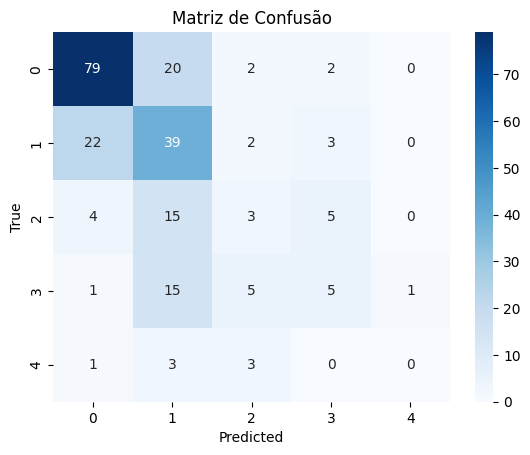

In [9]:
x_train, x_test, y_train, y_test = preparar_datasets(test_size_=0.25)
model = RandomForestClassifier(n_estimators=200, class_weight='balanced')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

f1_score_ = f1_score(y_test, y_pred, average='macro')
print (f'f1_score_: {f1_score_:.2f}')

confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

- Muito ruim. Ficou muito baixa a performance do modelo Random Forest

---
- Utilizando modelo knn

f1_score_: 0.33


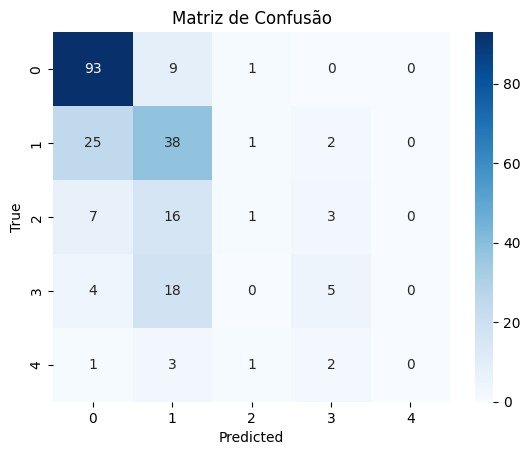

In [10]:
x_train, x_test, y_train, y_test = preparar_datasets(test_size_=0.25)

model = KNeighborsClassifier(n_neighbors=15, weights='uniform', metric='nan_euclidean')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

f1_score_ = f1_score(y_test, y_pred, average='macro')
print (f'f1_score_: {f1_score_:.2f}')

confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

---
- Utilizando Redes Neurais simples

f1_score_: 0.30


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


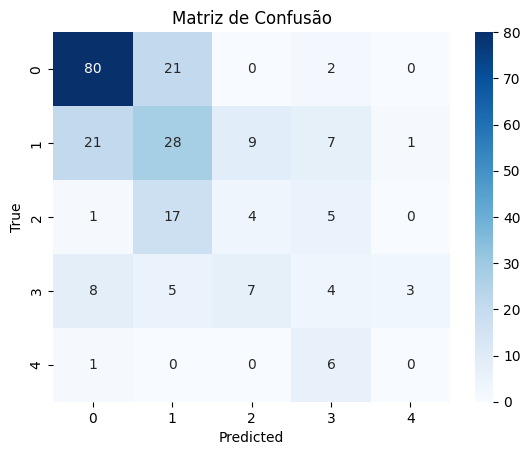

In [11]:
x_train, x_test, y_train, y_test = preparar_datasets(test_size_=0.25)

model = MLPClassifier(hidden_layer_sizes=(256, 128))
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

f1_score_ = f1_score(y_test, y_pred, average='macro')
print (f'f1_score_: {f1_score_:.2f}')

confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

---
- Agora um modelo "Burro"

f1_score_: 0.12


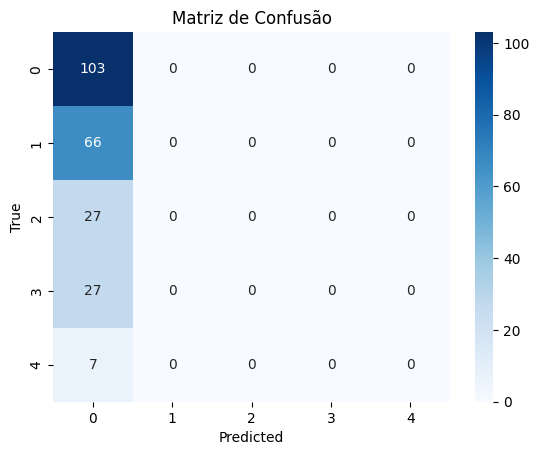

In [12]:
x_train, x_test, y_train, y_test = preparar_datasets(test_size_=0.25)

model = DummyClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

f1_score_ = f1_score(y_test, y_pred, average='macro')
print (f'f1_score_: {f1_score_:.2f}')

confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

---
- O dataset está muito desbalanceado. Vamos tentar duas alternativas:
- 1ª) Remover várias instâncias das classes dominantes para ver se os modelos ficam menos insensíveis com as classes minoritárias;
- 2ª) Utilizar bibliotecas que criam instâncias "falsas" para a classe minoritária e ver se aumenta a sensibilidade desta;

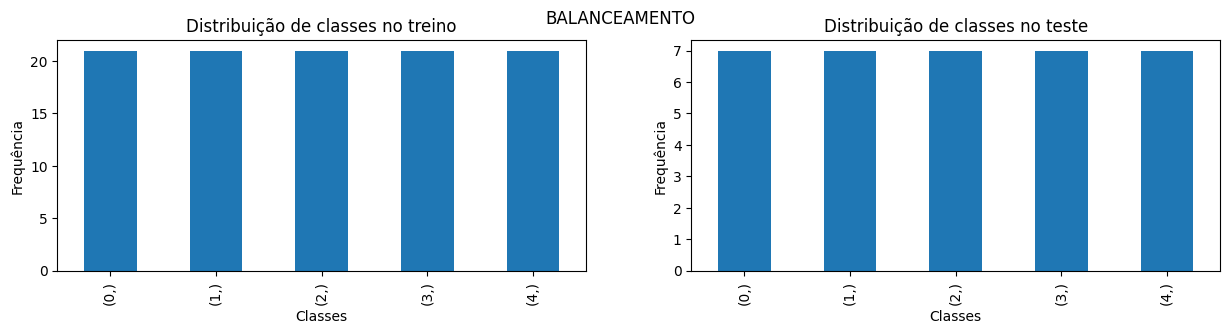

In [13]:
def preparar_dataset_balanceado(test_size_=0.25):
    """Função completa que traz os datasets já tratados em treino, teste"""
    knn_inputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')
    
    df = dataset.copy()
    df = df.replace('?', np.nan)
    df = df.astype(float)
    df_inputed = knn_inputer.fit_transform(df)

    df = pd.DataFrame(df_inputed, columns=df.columns)
    df['target'] = df['target'].astype(int)

    #  balanceamento das classes ==================================
    frequencias = df['target'].value_counts() # lista das frequencias de cada classe. E cada classe está em seu respectivo índice deste vetor
    menor_frequencia = frequencias.min() # menor frequência entre as classes
    classe_da_menor_frequencia = frequencias[frequencias == menor_frequencia].index[0] # índice da classe com menor frequência

    lista_datasets = []
    for k in range(len(frequencias)):
        if k == classe_da_menor_frequencia:
            df_aux = df[df['target'] == classe_da_menor_frequencia] # pega toda a classe de menor frequencia
        else:
            df_aux = df[df['target'] == k].sample(menor_frequencia)
        
        lista_datasets.append(df_aux)

    df_balanceado = pd.concat(lista_datasets)
    #  balanceamento das classes ==================================

    df_train = df_balanceado.copy().drop(columns=['target'])
    df_test = df_balanceado.copy()['target']

    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_train = scaler.fit_transform(df_train)

    x_train, x_test, y_train, y_test = train_test_split(df_train, df_test, test_size=test_size_, stratify=df_test)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preparar_dataset_balanceado(test_size_=0.25)

grafico = plt.figure(figsize=(15, 3))

grafico.add_subplot(1, 2, 1)
pd.DataFrame(y_train).value_counts().plot(kind='bar', title='Distribuição de classes no treino', xlabel='Classes', ylabel='Frequência')

grafico.add_subplot(1, 2, 2)
pd.DataFrame(y_test).value_counts().plot(kind='bar', title='Distribuição de classes no teste', xlabel='Classes', ylabel='Frequência')

# escrever titulo da figura
plt.suptitle('BALANCEAMENTO')

plt.show()

---
- Tentando novamente utilizando Random Forest

f1_score_: 0.55


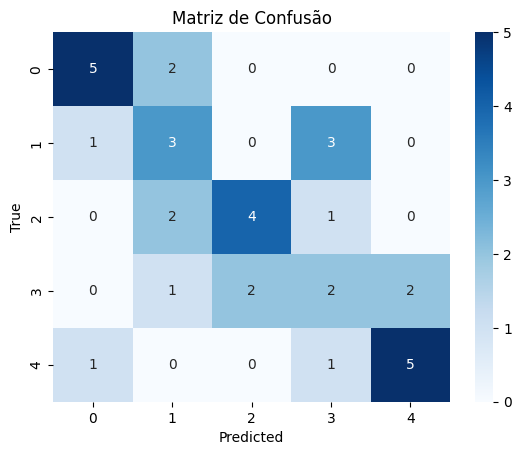

In [49]:
x_train, x_test, y_train, y_test = preparar_dataset_balanceado(test_size_=0.25)

model = RandomForestClassifier(n_estimators=400, class_weight='balanced')
# model = MLPClassifier(hidden_layer_sizes=(256, 128))
# model = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='nan_euclidean')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

f1_score_ = f1_score(y_test, y_pred, average='macro')
print (f'f1_score_: {f1_score_:.2f}')

confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()